#### Input features in order:
1) CRIM: per capita crime rate by town
2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3) INDUS: proportion of non-retail business acres per town
4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]
6) RM: average number of rooms per dwelling
7) AGE: proportion of owner-occupied units built prior to 1940
8) DIS: weighted distances to five Boston employment centres
9) RAD: index of accessibility to radial highways
10) TAX: full-value property-tax rate per $10,000 [$/10k]
11) PTRATIO: pupil-teacher ratio by town
12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13) LSTAT: % lower status of the population

Output variable:
1) MEDV: Median value of owner-occupied homes in $1000's [k$]

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [20]:
imported = pd.read_csv('housing_bos.csv',header=None, delimiter=r'\s+')

In [21]:
data = imported.copy()

In [37]:
columns = 'CRIM ZN INDUS CHAS NOX ROOMS_PER_HOUSE AGE<1940 DIS RAD TAX PTRATIO B LSTAT MEDV'.split()

In [38]:
data.columns = columns
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,ROOMS_PER_HOUSE,AGE<1940,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


array([[<Axes: title={'center': 'CRIM'}>, <Axes: title={'center': 'ZN'}>,
        <Axes: title={'center': 'INDUS'}>,
        <Axes: title={'center': 'CHAS'}>],
       [<Axes: title={'center': 'NOX'}>,
        <Axes: title={'center': 'ROOMS_PER_HOUSE'}>,
        <Axes: title={'center': 'AGE<1940'}>,
        <Axes: title={'center': 'DIS'}>],
       [<Axes: title={'center': 'RAD'}>, <Axes: title={'center': 'TAX'}>,
        <Axes: title={'center': 'PTRATIO'}>,
        <Axes: title={'center': 'B'}>],
       [<Axes: title={'center': 'LSTAT'}>,
        <Axes: title={'center': 'MEDV'}>, <Axes: >, <Axes: >]],
      dtype=object)

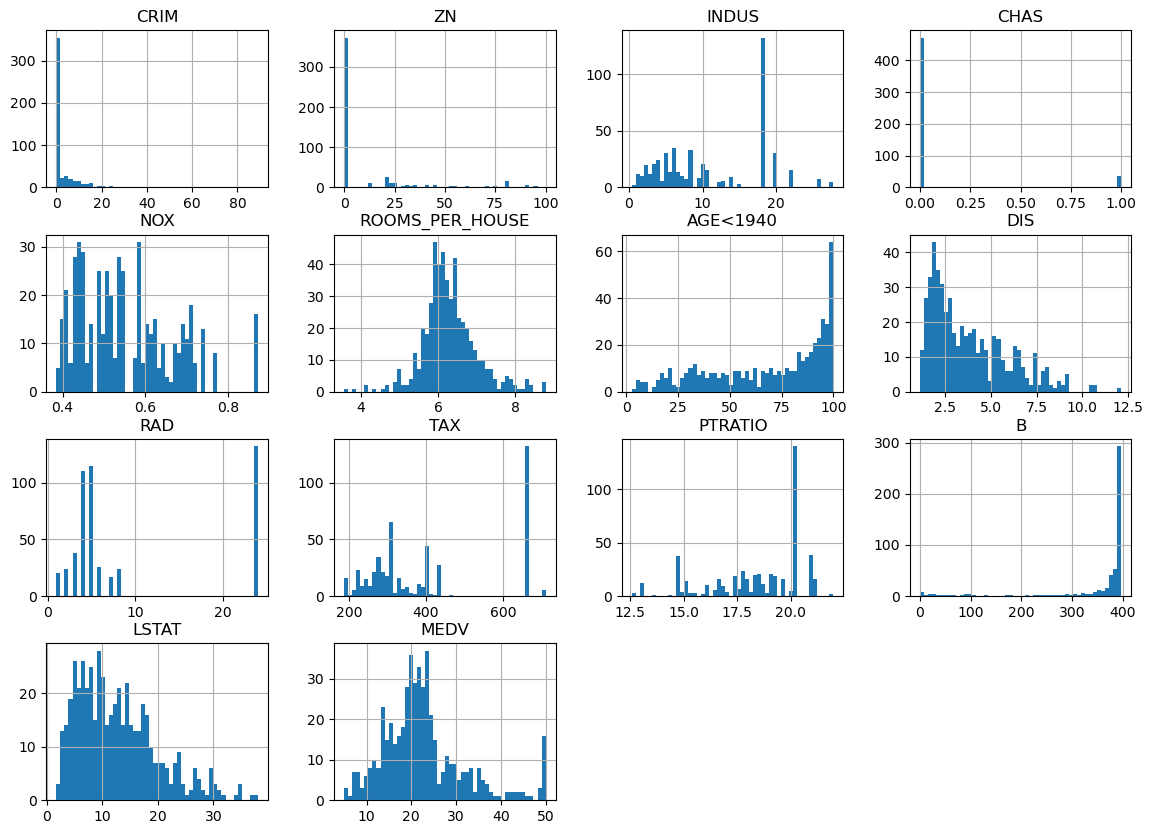

In [39]:
data.hist(figsize=(14,10), bins=50)

c:\Users\wasif\miniconda3\envs\data\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Axes: >

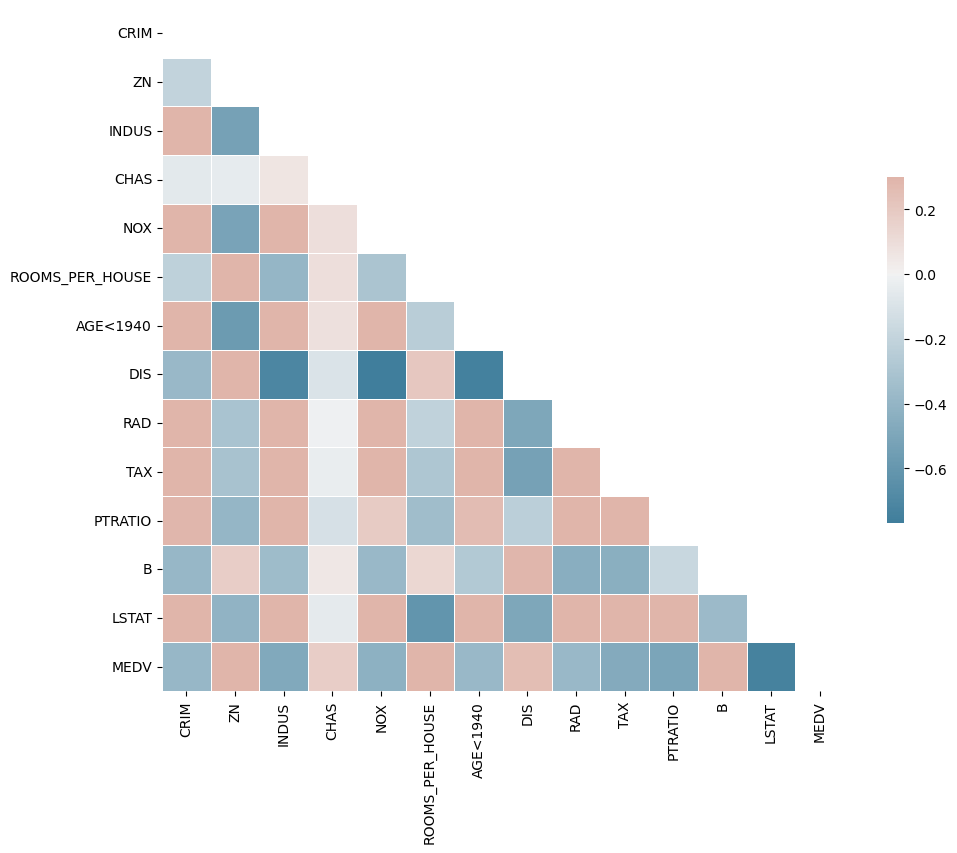

In [43]:
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})